# Simple Multi-particle simulations

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

f = h5py.File('particle-simulation.h5', 'w')

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def free_particles(time, num_particles=100, bound=(-5, 5), dimensions=2, X=None, P=None, **kwargs):
    upper_bnds = np.array([[bound[1], bound[1]]])
    lower_bnds = np.array([[bound[0], bound[0]]])
    
    if X is None:
        X = np.empty(time.shape[0], num_particles, dimensions)
    
    if P is None:
        P = np.empty(time.shape[0], num_particles, dimensions)
    
    X[0, :, :] = np.random.rand(num_particles, dimensions) - 0.5
    P[0, :, :] = np.random.randn(num_particles, dimensions)
    
    for i, dt in enumerate(np.diff(time)):
        X[i+1] = X[i] + dt*P[i]
        P[i+1] = P[i] - 2*P[i]*(1.0*(X[i+1] < lower_bnds) + 1.0*(X[i+1] > upper_bnds))

f.create_group('free-particle')
params = dict(
    time = np.arange(0, 5, 1e-3),
    num_particles = 100,
    dimensions = 2
)
params['shape'] = (params['time'].shape[0], params['num_particles'], params['dimensions'])
params['X'] = f['free-particle'].create_dataset('X', params['shape'])
params['P'] = f['free-particle'].create_dataset('P', params['shape'])

free_particles(**params)

In [3]:
def spherical_particles(time, num_particles=100, bound=(-5, 5), dimensions=2, X=None, P=None, 
                        force_constant=1e-3, **kwargs):
    upper_bnds = np.array([[bound[1], bound[1]]])
    lower_bnds = np.array([[bound[0], bound[0]]])
    
    if X is None:
        X = np.empty(time.shape[0], num_particles, dimensions)
    
    if P is None:
        P = np.empty(time.shape[0], num_particles, dimensions)
    
    X[0, :, :] = np.random.rand(num_particles, dimensions) - 0.5
    P[0, :, :] = np.random.randn(num_particles, dimensions)

    def collision_force(X):
        D = force_constant*(X.reshape(-1, 1, dimensions) - X.reshape(1, -1, dimensions))
        
        F = -force_constant*np.sum(np.nan_to_num(D/np.linalg.norm(D, axis=2)[:, :,np.newaxis]**6.0), axis=1)
        return F
    
    for i, dt in enumerate(np.diff(time)):
        X[i+1] = X[i] + dt*P[i]
        P[i+1] = P[i] - dt*collision_force(X[i+1]) - 2*P[i]*(1.0*(X[i+1] < lower_bnds) + 1.0*(X[i+1] > upper_bnds))

In [18]:
if not 'spherical-particle' in f:
    f.create_group('spherical-particle')
params = dict(
    time = np.arange(0, 5, 1e-4),
    num_particles = 2000,
    dimensions = 2,
    force_constant = 1.0e2
)
params['shape'] = (params['time'].shape[0], params['num_particles'], params['dimensions'])

if 'spherical-particle/X' in f:
    del f['spherical-particle']['X']
if 'spherical-particle/P' in f:
    del f['spherical-particle']['P']

params['X'] = f['spherical-particle'].create_dataset('X', params['shape'])
params['P'] = f['spherical-particle'].create_dataset('P', params['shape'])

ValueError: Not a location (invalid object ID)

In [ ]:
spherical_particles(**params)
plt.plot(params['time'], f['spherical-particle']['X'][:, :10, 0])

In [14]:
f.close()

# Animations

In [15]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

f = h5py.File('particle-simulation.h5')

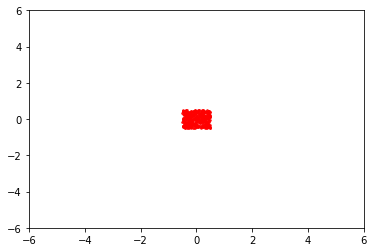

In [16]:
fig, ax = plt.subplots()
ax.set_xlim(-1.2*5, 1.2*5)
ax.set_ylim(-1.2*5, 1.2*5)

X = f['spherical-particle']['X']
scat = ax.scatter(X[0, :, 0], X[0, :, 1], s=np.pi, c='r', alpha=0.7)
def update(frame_number):
    scat.set_offsets(X[frame_number])

FuncAnimation(fig, update, interval=1, frames=5000)

In [17]:
f.close()